# **Imports**

In [ ]:
%pip install stanza
%pip install tensorflow scipy
%pip install scikit-learn
%pip install dateparser
%pip install gdown
%pip install gensim


In [ ]:
import pandas as pd
import numpy as np
import nltk
import gdown
import re
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
import joblib
import dateparser
import gzip
import shutil
import pickle
from IPython.display import display, Markdown
from collections import Counter
from datasets import Dataset, DatasetDict
from itertools import islice
from math import log
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from scipy.stats import chi2_contingency
from scipy.sparse import vstack, hstack
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback)
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import torch, torch.nn as nn
from wordcloud import WordCloud
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt_tab', quiet = True)
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')

# Google Drive file ID for GoogleNews-vectors-negative300.bin.gz
#url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
#output = "GoogleNews-vectors-negative300.bin.gz"

# Download the file
#gdown.download(url, output, quiet=False)

# Unzipping the .gz file
#with gzip.open("GoogleNews-vectors-negative300.bin.gz", "rb") as f_in:
    #with open("GoogleNews-vectors-negative300.bin", "wb") as f_out:
        #shutil.copyfileobj(f_in, f_out)


# **Data Exploration**

In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/datasets/Fake.csv", engine='python', on_bad_lines='skip')
df_true = pd.read_csv("/content/drive/MyDrive/datasets/True.csv", engine='python', on_bad_lines='skip')

df_fake['label'] = 0
df_true['label'] = 1

df = pd.concat([df_fake, df_true], ignore_index=True)

print("Fake dataset head:")
display(df_fake.head())

print("\nTrue dataset head:")
display(df_true.head())

In [ ]:
df_true.tail(10)

In [ ]:
df_fake.info()
df_true.info()

In [ ]:
df_true.describe(include='all')
df_fake.describe(include='all')

In [ ]:
print("Fake dataset shape:", df_fake.shape)
print("True dataset shape:", df_true.shape)

In [ ]:
df_true.nunique()
df_fake.nunique()

In [ ]:
f_null_values = df_fake.isnull().sum()
print(f_null_values)

In [ ]:
r_null_values = df_true.isnull().sum()
print(r_null_values)

In [ ]:
df_true['subject'].value_counts()

## **Seasonality**
Preparing and doing testing for correlations to Seasonality:

In [ ]:
def normalize_date_string(s: str) -> str:
    s = str(s).replace("\xa0", " ")
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r",(\S)", r", \1", s)   # ensure space after comma
    return s

def parse_date_series(s: pd.Series) -> pd.Series:
    s_norm = s.astype(str).apply(normalize_date_string)
    # URLs -> NaT
    is_url = s_norm.str.contains(r"https?://", case=False, na=False)
    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")
    # fast parse first
    fast = pd.to_datetime(s_norm[~is_url], errors="coerce")
    out.loc[~is_url] = fast
    # fallback with dateutil for remaining nulls
    mask = out.isna() & (~is_url)
    if mask.any():
        def safe_parse(x):
            try:
                # Ensure dateparser returns a datetime object or None/NaT
                parsed_date = dateparser.parse(x)
                return parsed_date if parsed_date is not None else pd.NaT
            except Exception:
                return pd.NaT
        # Apply safe_parse and explicitly convert to datetime
        out.loc[mask] = s_norm.loc[mask].apply(safe_parse).astype("datetime64[ns]")

    # Ensure the entire series is datetime64[ns]
    return out.astype("datetime64[ns]")


# 2) Parse dates separately for each file (so we can see which one is failing)
df_true["date"] = parse_date_series(df_true["date"])
df_fake["date"] = parse_date_series(df_fake["date"])


print("NaT in TRUE:", df_true["date"].isna().sum(), "of", len(df_true))
print("NaT in FAKE:", df_fake["date"].isna().sum(), "of", len(df_fake))

# 3) Combine cleanly, recompute helper features
df = pd.concat([df_fake, df_true], ignore_index=True)

# sanity on totals
print("\nTotals by label in df:")
print(df["label"].value_counts(dropna=False))


# 4) Build a seasonality-only view (drop rows lacking a usable date)
df_seasonal = df.dropna(subset=["date"]).copy()


# seasonality parts
df_seasonal["year"]     = df_seasonal["date"].dt.year
df_seasonal["month"]    = df_seasonal["date"].dt.to_period("M")
df_seasonal["dow_name"] = df_seasonal["date"].dt.day_name()


print("\nAfter dropping NaT dates:")
print(df_seasonal["label"].value_counts(dropna=False))
print("\nCounts per year x class:")
print(pd.crosstab(df_seasonal["year"], df_seasonal["label"]).fillna(0))

In [ ]:
# Yearly
yearly = df_seasonal.groupby(["year","label"]).size().unstack(fill_value=0)

ax = yearly.plot(kind="bar", stacked=True, figsize=(9,4),
                 title="Articles by Year (Fake vs True)")
ax.set_ylabel("Count")
ax.legend(["Fake (0)", "True (1)"])
plt.show()

# Monthly counts: number of fake and true articles per month
monthly = df_seasonal.groupby([df_seasonal["month"], "label"]).size().unstack(fill_value=0)

ax = monthly.plot(figsize=(12,4), title="Monthly Article Counts (Fake vs True)")
ax.set_ylabel("Count")
ax.legend(["Fake (0)", "True (1)"])
plt.show()

# Monthly % share: Percentage of true or fake articles per month
monthly_pct = (monthly.div(monthly.sum(axis=1), axis=0) * 100).fillna(0)

ax = monthly_pct.plot(figsize=(12,4), title="Monthly Share by Class (%)")
ax.set_ylabel("% of articles")
ax.legend(["Fake %", "True %"])
plt.show()

# Day of week counts
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow = df_seasonal.groupby([df_seasonal["dow_name"], "label"]).size().unstack(fill_value=0).reindex(order)

ax = dow.plot(kind="bar", figsize=(9,4), title="Articles by Day of Week (Fake vs True)")
ax.set_ylabel("Count")
ax.legend(["Fake (0)", "True (1)"])
plt.show()

In [ ]:
df_fake['subject'].value_counts()

### **Findings**
- True articles seem to be from 2016 and 2017. This is not a good parameter to judge off since that is specific to the database data.
- Usually more fake articles than true during the months. We see an increase of true articles near the end of 2017 but this could be due to data distribution.
- Significant count of fake articles come out on the weekends compared to true. Otherwise, usually an even mix on the weekdays.

### **Add Day-of-week Column**

In [ ]:
# Date
df["date"] = parse_date_series(df["date"])

# seasonality parts
df["dow_name"] = df["date"].dt.day_name()
df

## **Title and Text Length Histograms**

In [ ]:
df_true['title'].str.len().hist()

In [ ]:
df_fake['title'].str.len().hist()

In [ ]:
df_true['text'].str.len().hist()

In [ ]:
df_fake['text'].str.len().hist()

### **Adding Text and Title Length Column**

In [ ]:
df['textLen'] = df['text'].str.len()
df['titleLen'] = df['title'].str.len()
df.head()

## **Top Freq. Words**

In [ ]:
faketext = df_fake['text']
realtext = df_true['text']

def top_freq_words(series, n=15): # passing in a series (pandas dataframe column)
  vectorizer = CountVectorizer(stop_words = 'english') # remove the common english stop words
  fitted_vectorizer = vectorizer.fit_transform(series.fillna("")) # create document - term matrix
  word_counts = fitted_vectorizer.toarray().sum(axis=0) # convert to numpy array and extract counts
  wordlist = vectorizer.get_feature_names_out()
  frequencies = dict(zip(wordlist, word_counts))
  return sorted(frequencies.items(), key = lambda x: x[1], reverse = True)[:n] # sort by max to min frequency counts, only want the n entries

print(top_freq_words(faketext))
print(top_freq_words(realtext))

## **"Reuters" Usage**

In [ ]:
row_fake_reuter = df_fake['text'].str.contains("Reuters", case=False, na=False)
print(f"Number of rows containing 'Reuters' in FAKE data: {row_fake_reuter.sum()}")

count_reuters_text_fake = df_fake['text'].str.count("Reuters").sum()
print(f"The word 'Reuters' appears {int(count_reuters_text_fake)} times in the text column of the FAKE data")
df_fake['text'].shape

In [ ]:
count_reuters_text = df_true['text'].str.count("Reuters").sum()
print(f"The word 'Reuters' appears {int(count_reuters_text)} times in the text column of the TRUE data.")

row_reuter = df_true['text'].str.contains("Reuters", case=False, na=False)
print(f"Number of rows containing 'Reuters' in TRUE data: {row_reuter.sum()}")

df_true['text'].shape

In [ ]:
df.head()

In [ ]:
df.tail()

## **Punctuation**

### **Adding Punctuation Columns for Text and Title**

In [ ]:
# make sure we're on the cleaned frame
# df_punc = df.copy()

# Title counts
df["title_excl"]   = df["title"].astype(str).str.count("!")
df["title_qmark"]  = df["title"].astype(str).str.count(r"\?")
df["title_period"] = df["title"].astype(str).str.count(r"\.")
df["title_comma"]  = df["title"].astype(str).str.count(",")

# Body counts
df["text_excl"]    = df["text"].astype(str).str.count("!")
df["text_qmark"]   = df["text"].astype(str).str.count(r"\?")
df["text_period"]  = df["text"].astype(str).str.count(r"\.")
df["text_comma"]   = df["text"].astype(str).str.count(",")

# Per-word ratios (robust to length)
def n_words(s):
    return max(1, len(str(s).split()))

df["title_excl_per_word"]  = df.apply(lambda r: r["title_excl"]/n_words(r["title"]), axis=1)
df["title_qmark_per_word"] = df.apply(lambda r: r["title_qmark"]/n_words(r["title"]), axis=1)
df["text_excl_per_word"]   = df.apply(lambda r: r["text_excl"]/n_words(r["text"]), axis=1)
df["text_qmark_per_word"]  = df.apply(lambda r: r["text_qmark"]/n_words(r["text"]), axis=1)

# normalize label to {0,1}
df["label"] = (
    df["label"].astype(str).str.strip()
      .replace({"0":0,"1":1,"False":0,"True":1}).astype(int)
)


punct_cols = ["text_excl","text_qmark","text_period","text_comma",
              "title_excl","title_qmark","title_period","title_comma"]

present = [c for c in punct_cols if c in df.columns]
if not present:
    print("No punctuation columns found to plot.")
else:
    for col in present:
        fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

        # Left: full range (unclipped)
        for t, lab, color in [(0,"Fake (0)","tab:blue"), (1,"True (1)","tab:orange")]:
            vals = df.loc[df["label"]==t, col].dropna()
            axes[0].hist(vals, bins=50, alpha=0.5, label=lab, color=color)
        axes[0].set_title(f"{col} (Full Range)")
        axes[0].set_xlabel(f"Number of Punctuation: {col}"); axes[0].set_ylabel("Number of articles"); axes[0].legend()

        # Right: clipped at 20 (anything >20 shown as 20)
        for t, lab, color in [(0,"Fake (0)","tab:blue"), (1,"True (1)","tab:orange")]:
            vals = df.loc[df["label"]==t, col].clip(upper=20).dropna()
            axes[1].hist(vals, bins=20, alpha=0.5, label=lab, color=color)
        axes[1].set_title(f"{col} (Clipped at 20)")
        axes[1].set_xlabel(f"Number of Punctuation: {col}"); axes[0].set_ylabel("Number of articles"); axes[1].legend()

        plt.tight_layout()
        plt.show()


# Summary
summary = (
    df
    .groupby("label")[present]
    .agg(["mean","median","std","max"])
    .round(3)
    .rename(index={0:"Fake(0)",1:"True(1)"})
)
print(summary)


### **Findings**
**Title:**
  * Exclamation marks (!) on titles are associated with Fake News but I would further analyze
  * Question marks (?) on titles are associated with Fake News but I would further analyze

**Text:**
  * Multiple exclamation marks (!) correlated with Fake News
  * Multiple question marks (?) correlated with Fake News
  * No periods are a sign of Fake news

## **Contractions**

In [ ]:
count_contractions_text = df_true['text'].str.count("'").sum()
print(f"A contraction appears {int(count_contractions_text)} times in the text column of the TRUE data.")

count_contractions_title = df_true['title'].str.count("'").sum()
print(f"A contraction appears {int(count_contractions_title)} times in the title column in the TRUE data.")

count_contractions_ftext = df_fake['text'].str.count("'").sum()
print(f"A contraction appears {int(count_contractions_ftext)} times in the FAKE text column.")

count_contractions_ftitle = df_fake['title'].str.count("'").sum()
print(f"A contraction appears {int(count_contractions_ftitle)} times in the FAKE title column.")

In [ ]:
contractions = [
    "aren't", "can't", "couldn't", "didn't", "doesn't", "don't",
    "hadn't", "hasn't", "haven't", "he's", "I'm", "isn't", "it's",
    "let's", "mightn't", "mustn't", "shan't", "she's", "shouldn't",
    "that's", "there's", "they're", "we're", "weren't", "what's",
    "where's", "who's", "won't", "wouldn't", "you're", "you've",
    "i'm", "wasn't", "ain't", "could've", "would've", "should've",
    "we've", "they've", "it'll", "he'll", "she'll", "you'll", "we'll",
    "they'll", "i'll", "n't"
]

contraction_pattern = re.compile(r"\b(" + "|".join([re.escape(c) for c in contractions]) + r")\b", flags=re.IGNORECASE)

def get_top_contractions(series, top_n=15):
    all_text = " ".join(series.dropna().astype(str).tolist())
    found = contraction_pattern.findall(all_text)
    counts = Counter([c.lower() for c in found])
    return counts.most_common(top_n)

top_contractions_fake = get_top_contractions(df_fake['text'])
top_contractions_real = get_top_contractions(df_true['text'])

print("Top contractions in FAKE news:")
print(top_contractions_fake)

print("\nTop contractions in TRUE news:")
print(top_contractions_real)


### **Adding Contraction Count Column**

In [ ]:
pattern = r"\b(\w+)(['\s])(\w+)\b"
df['contractionCountText'] = df['text'].str.count(pattern)
df['contractionCountTitle'] = df['title'].str.count(pattern)
df.head()

# **Data Cleaning**

## **Cleaning Reuters**

In [ ]:
word_to_remove = '(Reuters)'
df['text'] =  df['text'].str.replace(r'[\(\-–\s]*Reuters[\)\s]*', '', case=False, regex=True)
df['text'] = df['text'].str.replace(r'^[A-Z]+(?:\s+[A-Z]+)*-\s*', '', regex=True)
df

## **Finding Empty-Space Cell**

In [ ]:
print(df_true[8970:8971])
print(df_true['text'].isnull().sum())
df_space = df_true["text"] == " "
result_df = df_space.loc[df_space==True]
print(result_df)

## Drop Subject

In [ ]:
# Drop Subject
df = df.drop(columns='subject')
df.head()

In [ ]:
df.tail()

# **Further Data Cleaning**

## **Removing Media Tag Lines**

In [ ]:
import re

pattern = r'[\[\(](VIDEO|IMAGE|TWEET|WATCH|PHOTO)[\]\)]'

# Count total occurrences across the entire column
fake_pattern_total = df_fake['title'].str.count(pattern, flags=re.IGNORECASE).sum()
fake_pattern_text = df_fake['text'].str.count(pattern, flags=re.IGNORECASE).sum()
print(fake_pattern_total, fake_pattern_text)

In [ ]:
true_pattern_total = df_true['title'].str.count(pattern, flags=re.IGNORECASE).sum()
true_pattern_text = df_true['text'].str.count(pattern, flags=re.IGNORECASE).sum()
print(true_pattern_total, true_pattern_text)

In [ ]:
df_fake['title'] = df_fake['title'].str.replace(
    r'[\[\(](VIDEO|IMAGE|TWEET|WATCH|PHOTO)[\]\)]',
    '', flags=re.IGNORECASE, regex=True)
df_fake['text'] = df_fake['text'].str.replace(
    r'[\[\(](VIDEO|IMAGE|TWEET|WATCH|PHOTO)[\]\)]',
    '', flags=re.IGNORECASE, regex=True)

In [ ]:
df_true['text'] = df_true['text'].str.replace(
    r'[\[\(](VIDEO|IMAGE|TWEET|WATCH|PHOTO)[\]\)]',
    '', flags=re.IGNORECASE, regex=True)

# **Feature Engineering**

## **Tokenization, Vectorization, and Lemmatization**

In [ ]:
# Remove stopwords
stop_words = stopwords.words("english")
df["title"] = df["title"].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop_words))
df["text"] = df["text"].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop_words))

# Lemmatization
wnl = WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: " ".join(wnl.lemmatize(word) for word in x.split()))
df["title"] = df["title"].apply(lambda x: " ".join(wnl.lemmatize(word) for word in x.split()))
print(df.head())

# # Tokenization - old code, could delete
# df['title'] = df['title'].apply(nltk.word_tokenize)
# df['text'] = df['text'].apply(nltk.word_tokenize)

# TOKENIZATION
df_title = df['title'].values
df_text = df['text'].values

vocab_size = 10000  # maximum number of words to keep
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df_title)
tokenizer.fit_on_texts(df_text)

# Convert texts to sequences of numbers
df['title_tk'] = tokenizer.texts_to_sequences(df_title)
df['text_tk'] = tokenizer.texts_to_sequences(df_text)


print(df)

# Vectorize + Splitting Data
y = df['label']
titles = df["title"].astype(str)
texts = df["text"].astype(str)

title_vectorizer = TfidfVectorizer(max_features=2000)
text_vectorizer = TfidfVectorizer(max_features=5000)
X_title = title_vectorizer.fit_transform(titles)
X_text = text_vectorizer.fit_transform(texts)


X = hstack([X_title, X_text])
vectorizer = TfidfVectorizer(max_features=5000)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state = 1234)

# Convert sparse matrix to dense and then DataFrame
feature_names = list(title_vectorizer.get_feature_names_out()) + list(text_vectorizer.get_feature_names_out())
df_X = pd.DataFrame(X.toarray(), columns=feature_names)
df_X['label'] = y.values



## **Frequency Based Embeddings using Bag of Words for Model Training**

In [ ]:
faketext = df[df['label'] == 0]['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
realtext = df[df['label'] == 1]['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))


# We fit one vectorizer on both fake + real text combined.
# This ensures both datasets share the same vocabulary (columns = same words).
vectorizer = CountVectorizer(stop_words='english')  # remove common filler words like "the", "and"
vectorizer.fit(pd.concat([faketext, realtext]))

# Transform each dataset separately to get their word-count matrices
X_fake_text = vectorizer.transform(faketext)
X_real_text = vectorizer.transform(realtext)

print(vectorizer.get_feature_names_out())

print(X_fake_text)
print(X_real_text)

## **TFIDF**

In [41]:
# Train test split

# Create all_text column by combining title + text
df["all_text"] = df["title"].astype(str) + " " + df["text"].astype(str)
df["title_len"] = df["title"].str.len()
df["text_len"] = df["text"].str.len()


meta_data_tfidf_punc = [
    "title_excl","title_qmark","title_period","title_comma",
    "text_excl","text_qmark","text_period","text_comma",
    "title_excl_per_word","title_qmark_per_word",
    "text_excl_per_word","text_qmark_per_word",
    "title_len", "text_len"
]

X = df[["all_text"] + meta_data_tfidf_punc]
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((31280, 15), (7820, 15))

In [42]:
# Text + numeric preprocessors
text_vec = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),    # unigrams + bigrams
    max_features=100_000,
    min_df=2
)

preprocess = ColumnTransformer(
    transformers=[
        ("tfidf", text_vec, "all_text"),
        ("num",   StandardScaler(with_mean=False), meta_data_tfidf_punc),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

clf = LogisticRegression(
    max_iter=1000,
    solver="liblinear"
)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf",  clf),
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=100000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'all_text'),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  ['title_excl', 'title_qmark',
                                                   'title_period',
                                                   'title_comma', 'text_excl',
                                                   'text_qmark', 'text_period',
                                                   'text_comma',
                                                   'title_excl_per_word',
                                                   'title_qmark_per_word',
                                                   'text_excl_per_word',
                                                   'text_qmark_per_word',
                                                   'title_len',
                                                   'text_len'])])),
                ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

In [43]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
cm


              precision    recall  f1-score   support

           0      0.989     0.975     0.982      3581
           1      0.979     0.991     0.985      4239

    accuracy                          0.984      7820
   macro avg      0.984     0.983     0.984      7820
weighted avg      0.984     0.984     0.984      7820

ROC-AUC: 0.9975893056714165


array([[3492,   89],
       [  38, 4201]])

#### **Findings**
Only 118 = 92+26 mistakes in total. This is extremely well which could suggest data leakage.

In [44]:
# Get feature names for tfidf part
tfidf = pipe.named_steps["prep"].named_transformers_["tfidf"]
tfidf_vocab = tfidf.get_feature_names_out()
n_tfidf = len(tfidf_vocab)

# Coefs come from the final LR over [tfidf | scaled meta]
coefs = pipe.named_steps["clf"].coef_.ravel()

tfidf_coefs = coefs[:n_tfidf]
top_true_idx  = np.argsort(tfidf_coefs)[-25:][::-1]   # highest positive → True(1)
top_fake_idx  = np.argsort(tfidf_coefs)[:25]          # most negative → Fake(0)

print("\nTop tokens predicting TRUE (1):")
for i in top_true_idx:
    print(f"{tfidf_vocab[i]:<25}  {tfidf_coefs[i]:.4f}")

print("\nTop tokens predicting FAKE (0):")
for i in top_fake_idx:
    print(f"{tfidf_vocab[i]:<25}  {tfidf_coefs[i]:.4f}")



Top tokens predicting TRUE (1):
said                       14.1127
president donald           3.8723
wednesday                  3.8183
tuesday                    3.6689
thursday                   3.5695
minister                   3.4341
friday                     3.3028
edt                        3.2559
republican                 3.0731
monday                     2.9300
spokesman                  2.4464
party                      2.4226
presidential               2.4133
government                 2.3354
nov                        2.2401
comment                    2.2383
china                      2.1622
statement                  2.1417
said statement             2.1095
democratic                 2.0889
britain                    2.0722
parliament                 2.0622
opposition                 2.0539
leader                     2.0408
house                      2.0240

Top tokens predicting FAKE (0):
video                      -6.6367
image                      -6.0786
featured     

Positive correlation means likely to be correlated to True News and anything negative is associated with Fake News.

**Next step:** Look into getting trying the model without "reuters" and "said".

### **Model without "Reuters and Said"**

In [45]:
#Make a cleaned text column
BAD_TOKENS = {"reuters", "said"}
pattern = re.compile(r"\b(" + "|".join(map(re.escape, BAD_TOKENS)) + r")\b", flags=re.IGNORECASE)

def remove_bad_tokens(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return pattern.sub("", s)

df["all_text_clean"] = df["all_text"].apply(remove_bad_tokens)

#The rest is creating a TD-IDF

text_vec = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    max_features=100_000,
    min_df=2,
    max_df=0.9,
)

preprocess = ColumnTransformer(
    transformers=[
        ("tfidf", text_vec, "all_text_clean"),  # ← use the cleaned column
        ("num",   StandardScaler(with_mean=False), meta_data_tfidf_punc),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

clf = LogisticRegression(max_iter=1000, solver="liblinear")

pipe2 = Pipeline([
    ("prep", preprocess),
    ("clf",  clf),
])

pipe2

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  max_features=100000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'all_text_clean'),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  ['title_excl', 'title_qmark',
                                                   'title_period',
                                                   'title_comma', 'text_excl',
                                                   'text_qmark', 'text_period',
                                                   'text_comma',
                                                   'title_excl_per_word',
                                                   'title_qmark_per_word',
                                                   'text_excl_per_word',
                                                   'text_qmark_per_word',
                                                   'title_len',
                                                   'text_len'])])),
                ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

In [46]:
X1 = df[["all_text_clean"] + meta_data_tfidf_punc]
y = df["label"].astype(int)

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y, test_size=0.20, stratify=y, random_state=42
)

pipe2.fit(X_train1, y_train1)
y_pred = pipe2.predict(X_test1)
y_prob = pipe2.predict_proba(X_test1)[:,1]

print(classification_report(y_test1, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test1, y_prob))

cm2 = confusion_matrix(y_test1, y_pred)
cm2


              precision    recall  f1-score   support

           0      0.990     0.970     0.980      3581
           1      0.975     0.992     0.983      4239

    accuracy                          0.982      7820
   macro avg      0.982     0.981     0.981      7820
weighted avg      0.982     0.982     0.982      7820

ROC-AUC: 0.9971396308753593


array([[3473,  108],
       [  36, 4203]])

#### **Findings**
- Accuracy droppped (0.987 -> 0.984)
- Model misses a few more fake
- ROC-AUC stayed around the same

Accuracy and ROC-AUC scores would've dropped more significantly if "reuters" and "said" would've been more legit signals of truthfulness. I would say, at this point, it is same to assume these words caused data leakage.

In [47]:
df.head(10)

,title,text,date,label,dow_name,textLen,titleLen,title_excl,title_qmark,title_period,...,text_excl_per_word,text_qmark_per_word,contractionCountText,contractionCountTitle,title_tk,text_tk,all_text,title_len,text_len,all_text_clean
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump wish Americans Happy New Year lea...,2017-12-31,0,Sunday,2893,79,0,0,0,...,0.012121,0.018182,223,5,"[21, 2, 4845, 340, 2688, 17, 3611, 4399, 495, ...","[21, 2, 1986, 161, 1627, 17, 15, 629, 53, 497,...",Donald Trump Sends Out Embarrassing New Year’s...,75,2169,Donald Trump Sends Out Embarrassing New Year’s...
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,2017-12-31,0,Sunday,1898,69,0,0,0,...,0.000000,0.000000,148,4,"[6541, 5544, 2, 2200, 890, 129, 1661, 187]","[19, 220, 163, 567, 5755, 3021, 82, 628, 58, 2...",Drunk Bragging Trump Staffer Started Russian C...,68,1441,Drunk Bragging Trump Staffer Started Russian C...
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, revealed former Milwaukee Sheriff D...",2017-12-30,0,Saturday,3597,90,0,0,0,...,0.003448,0.006897,262,7,"[1829, 870, 5938, 2545, 833, 1057, 2152, 125, ...","[90, 155, 1330, 51, 5344, 1829, 870, 5938, 113...",Sheriff David Clarke Becomes An Internet Joke ...,89,2751,Sheriff David Clarke Becomes An Internet Joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced would...",2017-12-29,0,Friday,2774,78,0,0,0,...,0.000000,0.002252,206,7,"[2, 182, 165, 5317, 25, 55, 1513, 823, 410, 1,...","[90, 2044, 58, 21, 2, 576, 9, 74, 130, 395, 58...",Trump Is So Obsessed He Even Has Obama’s Name ...,77,2145,Trump Is So Obsessed He Even Has Obama’s Name ...
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used annual Christmas Day message...,2017-12-25,0,Monday,2346,70,0,0,0,...,0.000000,0.000000,200,5,"[1969, 2943, 633, 96, 340, 21, 2, 752, 341, 20...","[1969, 2943, 224, 1570, 2044, 58, 495, 5546, 2...",Pope Francis Just Called Out Donald Trump Duri...,69,1533,Pope Francis Just Called Out Donald Trump Duri...
5,Racist Alabama Cops Brutalize Black Boy While ...,The number case cop brutalizing killing people...,2017-12-25,0,Monday,1741,82,0,0,0,...,0.000000,0.003205,148,6,"[534, 1573, 3542, 1, 147, 1479, 377, 25, 182, ...","[4, 235, 134, 1488, 1, 969, 10, 1959, 783, 119...",Racist Alabama Cops Brutalize Black Boy While ...,81,1158,Racist Alabama Cops Brutalize Black Boy While ...
6,"Fresh Off The Golf Course, Trump Lashes Out At...","Donald Trump spent good portion day golf club,...",2017-12-23,0,Saturday,2166,83,0,0,0,...,0.008523,0.008523,165,7,"[2926, 975, 4, 2099, 449, 2, 1, 340, 233, 204,...","[21, 2, 893, 195, 3279, 58, 2099, 1744, 6972, ...","Fresh Off The Golf Course, Trump Lashes Out At...",82,1666,"Fresh Off The Golf Course, Trump Lashes Out At..."
7,Trump Said Some INSANELY Racist Stuff Inside T...,In wake yet another court decision derailed Do...,2017-12-23,0,Saturday,2224,87,0,0,0,...,0.000000,0.002660,179,7,"[2, 3, 563, 1, 534, 2501, 1026, 4, 2777, 100, ...","[16, 2045, 319, 145, 63, 200, 1, 21, 2, 132, 1...",Trump Said Some INSANELY Racist Stuff Inside T...,86,1546,Trump Some INSANELY Racist Stuff Inside The O...
8,Former CIA Director Slams Trump Over UN Bullyi...,Many people raised alarm regarding fact Donald...,2017-12-22,0,Friday,2772,102,0,0,0,...,0.000000,0.000000,214,7,"[51, 830, 255, 8664, 2, 759, 1292, 4613, 2150,...","[59, 10, 922, 3820, 1256, 199, 21, 2, 9905, 45...",Former CIA Director Slams Trump Over UN Bullyi...,101,2022,Former CIA Director Slams Trump Over UN Bullyi...
9,WATCH: Brand-New Pro-Trump Ad Features So Much...,Just might thought get break watching people k...,2017-12-21,0,Thursday,1644,81,0,0,0,...,0.000000,0.000000,138,7,"[173, 2531, 17, 617, 2, 1119, 1, 165, 143, 27,...","[633, 310, 594, 57, 1095, 1797, 10, 5753, 21, ...",WATCH: Brand-New Pro-Trump Ad Features So Much...,80,1182,WATCH: Brand-New Pro-Trump Ad Features So Muc

# Modeling

## SVM Model

Deduped size: 39100
Train: 27370, Val: 7820, Test: 3910
Label share (pos=1) -> Train: 0.542, Val: 0.542, Test: 0.542

=== VALIDATION metrics ===
              precision    recall  f1-score   support

           0      0.997     0.996     0.997      3581
           1      0.997     0.997     0.997      4239

    accuracy                          0.997      7820
   macro avg      0.997     0.997     0.997      7820
weighted avg      0.997     0.997     0.997      7820

Confusion matrix:
 [[3568   13]
 [  12 4227]]
ROC-AUC: 1.000


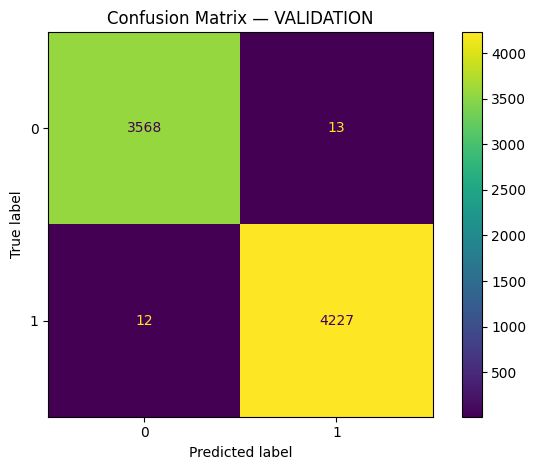


=== TEST metrics ===
              precision    recall  f1-score   support

           0      0.998     0.994     0.996      1791
           1      0.995     0.999     0.997      2119

    accuracy                          0.997      3910
   macro avg      0.997     0.997     0.997      3910
weighted avg      0.997     0.997     0.997      3910

Confusion matrix:
 [[1781   10]
 [   3 2116]]
ROC-AUC: 1.000


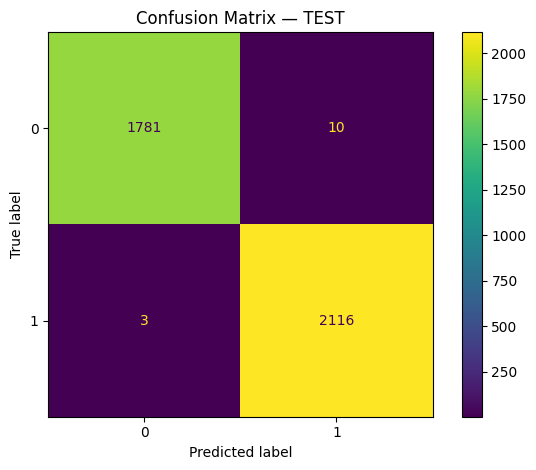


CV accuracy (train+val): mean=0.998 ± 0.000

Saved model -> svm_text_classifier_no_leak.joblib


In [40]:
# def prepare(df: pd.DataFrame, label: int) -> pd.DataFrame:
#     out = df.copy()
#     out["label"] = label
#     out["title"] = out["title"].fillna("")
#     out["text"]  = out["text"].fillna("")
#     return out[["title", "text", "label"]]

# Join the lists of tokens back into strings before dropping duplicates
df['title'] = df['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df['text'] = df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# remove exact duplicates
df = df.drop_duplicates(subset=["title", "text", "label"]).reset_index(drop=True)
print("Deduped size:", len(df))

X = df[["title", "text"]]
y = df["label"].astype(int)

# 1) Stratified split: 70/20/10

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Label share (pos=1) -> Train: {y_train.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}")

# 2) Preprocessing: TF-IDF only

tfidf_title = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9, lowercase=True)
tfidf_text  = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, lowercase=True)

preprocess = ColumnTransformer(
    transformers=[
        ("title_tfidf", tfidf_title, "title"),
        ("text_tfidf",  tfidf_text,  "text")
    ],
    sparse_threshold=1.0
)

# 3) Build SVM pipeline

clf = Pipeline([
    ("preprocess", preprocess),
    ("svm", LinearSVC(C=1.0, class_weight="balanced", random_state=42))
])

# 4) Train

clf.fit(X_train, y_train)

# 5) Evaluate helper

def evaluate(split_name, X_split, y_split):
    y_pred = clf.predict(X_split)
    print(f"\n=== {split_name} metrics ===")
    print(classification_report(y_split, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_split, y_pred))

    # ROC-AUC using decision_function
    try:
        y_score = clf.decision_function(X_split)
        auc = roc_auc_score(y_split, y_score)
        print(f"ROC-AUC: {auc:.3f}")
    except Exception as e:
        print("[info] AUC not available:", e)

    try:
        ConfusionMatrixDisplay.from_predictions(y_split, y_pred)
        plt.title(f"Confusion Matrix — {split_name}")
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

# Evaluate
evaluate("VALIDATION", X_val, y_val)
evaluate("TEST", X_test, y_test)

# 6) CV on train+val

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_trval, y_trval, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"\nCV accuracy (train+val): mean={cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 7) Save model
with open("svm_text_classifier_no_leak.pkl", "wb") as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

joblib.dump(clf, "svm_text_classifier_no_leak.joblib")
print("\nSaved model -> svm_text_classifier_no_leak.joblib")

# 8) Eventually load later...
# with open("svm_text_classifier_no_leak.pkl", "rb") as f:
#     clf = pickle.load(f)


## LSTM

In [48]:
# LSTM model with tokenization - Arif

# Combine title and text for context
df['combined_text'] = df['title'].astype(str) + ' ' + df['text'].astype(str)

X_text = df['combined_text'].values
y = df['label'].values

print(f"Number of samples: {len(X_text)}")
print(f"Sample text: {X_text[0][:100]}...")  # show first 100 chars

# Step 2: Tokenize text to numbers
vocab_size = 10000  # maximum number of words to keep
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_text)

# Convert texts to sequences of numbers
X_sequences = tokenizer.texts_to_sequences(X_text)

print(f"Sample sequence: {X_sequences[0][:20]}...")  # show first 20 tokens

# Step 3: Pad sequences to same length
max_len = 100
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

print(f"Padded shape: {X_padded.shape}")

# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Step 5: Build LSTM model
model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # for binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()

# Step 6: Train
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Step 7: Evaluate
print("\nEvaluating on test set...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Step 8: Make predictions
predictions = model.predict(X_test)
pred_classes = (predictions > 0.5).astype(int).flatten()

# Step 9: Show detailed results
print("\n" + "="*50)
print("RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred_classes))

model.save('fake_news_lstm_model.keras')

joblib.dump(tokenizer, 'tokenizer.pkl')

print("Model and tokenizer saved successfully!")


Number of samples: 39100
Sample text: Donald Trump Sends Out Embarrassing New Year’s Eve Message; This Disturbing Donald Trump wish Americ...
Sample sequence: [20, 3, 4787, 356, 2804, 17, 3217, 4642, 501, 42, 2990, 20, 3, 2008, 174, 1616, 17, 15, 595, 51]...
Padded shape: (39100, 100)
Training samples: 31280
Test samples: 7820

Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - accuracy: 0.8628 - loss: 0.3381 - val_accuracy: 0.9781 - val_loss: 0.0943
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 118ms/step - accuracy: 0.9677 - loss: 0.1296 - val_accuracy: 0.9815 - val_loss: 0.0848
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 115ms/step - accuracy: 0.9776 - loss: 0.1010 - val_accuracy: 0.9811 - val_loss: 0.0869
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 118ms/step - accuracy: 0.9811 - loss: 0.0764 - val_accuracy: 0.9864 - val_loss: 0.0617
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 116ms/step - accuracy: 0.9871 - loss: 0.0537 - val_accuracy: 0.9899 - val_loss: 0.0459
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 117ms/step - accuracy: 0.9903 - loss: 0.0392 - val_accuracy: 0.9896 - val_loss: 0.0488
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 117ms/step - accuracy: 0.9923 - loss: 0.0317 - val_accuracy: 0.9895 - val_loss: 0.0617
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 118ms/step - ac

The LSTM model achieved high performance with a test accuracy of 99.32% on the unseen test data. Out of 8,980 test articles, the model correctly classified 8,919 articles and made only 61 mistakes total—41 false positives and 20 false negatives. Both classes showed balanced performance with 99-100% precision and recall, indicating the model learned patterns rather than  memorize the training data. The confusion matrix shows 4,655 true negatives and 4,264 true positives, demonstrating the model's ability to accurately distinguish between the two news article categories with consistency. The model's learning progression was showed from the training epochs, starting at 80% accuracy in the first epoch and reaching 99.35% validation accuracy by epoch 7, at which point early stopping terminated the training to preserve the best-performing model.

## Naive Bayes

In [49]:
# Multinomial Naive Bayes Model trained with only fake and real text data

# combining faketext and realtext
X_all = vstack([X_fake_text, X_real_text])
y_all = np.concatenate([
    np.zeros(len(faketext)), #label 0 for fake
    np.ones(len(realtext)) # label 1 for real
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Train Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9418708240534521
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      4733
         1.0       0.94      0.93      0.94      4247

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



## Logistic Regression


In [52]:
# Combine title + text
df["all_text"] = df["title"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x)) + " " + \
                      df["text"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

y = df["label"]

# Train and test split
X_LR_train_text, X_LR_test_text, y_LR_train, y_LR_test = train_test_split(
    df["all_text"], y, test_size=0.2, stratify=y, random_state=42
)

# Vectorize
vectorizer_LR = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=100_000)
X_LR_train_tfidf = vectorizer_LR.fit_transform(X_LR_train_text)
X_LR_test_tfidf = vectorizer_LR.transform(X_LR_test_text)

# Train Logistic Regression
clf_LR = LogisticRegression(max_iter=1000, solver="liblinear")
clf_LR.fit(X_LR_train_tfidf, y_LR_train)

# Model Eval
y_LR_pred = clf_LR.predict(X_LR_test_tfidf)
y_LR_prob = clf_LR.predict_proba(X_LR_test_tfidf)[:, 1]
print(classification_report(y_LR_test, y_LR_pred))
print("ROC-AUC:", roc_auc_score(y_LR_test, y_LR_prob))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3581
           1       0.98      0.99      0.98      4239

    accuracy                           0.98      7820
   macro avg       0.98      0.98      0.98      7820
weighted avg       0.98      0.98      0.98      7820

ROC-AUC: 0.9978758037212335


In [53]:
# Get feature names from your TF-IDF vectorizer
feature_names_LR = vectorizer_LR.get_feature_names_out()

# Extract learned coefficients from your logistic regression model
coefs_LR = clf_LR.coef_[0]

# Top 10 predictors of TRUE (1)
top_true_idx = np.argsort(coefs_LR)[-10:][::-1]
print("Top features predicting TRUE (1):")
for i in top_true_idx:
    print(f"{feature_names_LR[i]:<25}  {coefs_LR[i]:.3f}")

# Top 10 predictors of FAKE (0)
top_fake_idx = np.argsort(coefs_LR)[:10]
print("\nTop features predicting FAKE (0):")
for i in top_fake_idx:
    print(f"{feature_names_LR[i]:<25}  {coefs_LR[i]:.3f}")

Top features predicting TRUE (1):
said                       18.593
president donald           6.496
wednesday                  5.781
tuesday                    5.506
thursday                   5.447
republican                 4.990
friday                     4.684
monday                     4.567
minister                   4.165
presidential               3.893

Top features predicting FAKE (0):
video                      -11.101
featured image             -6.613
image                      -6.556
featured                   -6.552
gop                        -6.223
read                       -6.063
hillary                    -5.963
president trump            -5.158
like                       -5.140
watch                      -5.129


Are words like "say" and "video" too strong of indicators that are causing data leakage and the reason why the LR model is so accurate?

## Random Forest

In [54]:
remove = ['date', 'dow_name','title','text']
df_RF = df.drop(columns = remove, axis = 1)
df_RF

y1 = df["label"]

# Train and test split
X_RF_train_text, X_RF_test_text, y_RF_train, y_RF_test = train_test_split(
    df["all_text"], y1, test_size=0.2, random_state=42
)

# Vectorize
vectorizer_RF = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=100_000)
X_RF_train_tfidf = vectorizer_RF.fit_transform(X_RF_train_text)
X_RF_test_tfidf = vectorizer_RF.transform(X_RF_test_text)

In [55]:
rf_model = RandomForestClassifier(criterion='entropy', n_estimators=20)
rf_model.fit(X_RF_train_tfidf, y_RF_train)
rf_model_pred = rf_model.predict(X_RF_test_tfidf)
print(accuracy_score(y_RF_test, rf_model_pred))

0.969693094629156


## **BERT Model**

In [60]:
#DF for model
df_BERT = df.copy()

#Make BERT input text
def build_text(row, mode="title+text"):
    if mode == "title":
        return f"Title: {row['title']}"
    elif mode == "text":
        return f"Body: {row['text']}"
    else:
        return f"Title: {row['title']}  [SEP]  Body: {row['text']}"


MODE = "title+text"   # 'title', 'text', or 'title+text'
df_BERT['input_text'] = df.apply(lambda r: build_text(r, MODE), axis=1)

df.head();


In [61]:
#Create Split
train_df_BERT, temp_df_BERT = train_test_split(df_BERT[['input_text','label']], test_size=0.2, random_state=42, stratify=df_BERT['label'])
val_df_BERT, test_df_BERT = train_test_split(temp_df_BERT,test_size=0.5, random_state=42, stratify=temp_df_BERT['label'])

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df_BERT.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df_BERT.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df_BERT.reset_index(drop=True)),
})


In [62]:
#Tokenize
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok(batch):
    return tokenizer(batch["input_text"], truncation=True, padding=False, max_length=MAX_LEN)

tokenized = ds.map(tok, batched=True, remove_columns=["input_text"])
data_collator = DataCollatorWithPadding(tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/31280 [00:00<?, ? examples/s]

Map:   0%|          | 0/3910 [00:00<?, ? examples/s]

Map:   0%|          | 0/3910 [00:00<?, ? examples/s]

In [63]:
#Class weight and metrics
y_BERT = train_df_BERT['label'].values
classes = np.unique(y_BERT)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_BERT)
class_weights = torch.tensor(weights, dtype=torch.float)
print("Class weights:", dict(zip(classes, weights)))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    return {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1}


Class weights: {np.int64(0): np.float64(1.0918737782742252), np.int64(1): np.float64(0.9223873555083746)}


In [64]:
#Model + Trainer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

model.config.use_cache = False
model.gradient_checkpointing_enable()

args = TrainingArguments(
    output_dir="bert_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=8,
    group_by_length=True,
    num_train_epochs=2,
    max_steps=600,
    learning_rate=2e-5,
    warmup_ratio=0.06,
    weight_decay=0.01,
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
#Train and Eval
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.014100,0.017883,0.996675,0.996232,0.997642,0.996936


In [66]:
print("Validation:", trainer.evaluate(eval_dataset=tokenized["validation"]))
test_metrics = trainer.evaluate(eval_dataset=tokenized["test"])
print("Test:", test_metrics)

Validation: {'eval_loss': 0.017822381108999252, 'eval_accuracy': 0.9966751918158567, 'eval_precision': 0.9962317475270843, 'eval_recall': 0.9976415094339622, 'eval_f1': 0.9969361300966297, 'eval_runtime': 1560.788, 'eval_samples_per_second': 2.505, 'eval_steps_per_second': 0.157, 'epoch': 0.3069053708439898}
Test: {'eval_loss': 0.019146669656038284, 'eval_accuracy': 0.9964194373401535, 'eval_precision': 0.9948283968030089, 'eval_recall': 0.9985842378480415, 'eval_f1': 0.9967027790861988, 'eval_runtime': 1561.4108, 'eval_samples_per_second': 2.504, 'eval_steps_per_second': 0.157, 'epoch': 0.3069053708439898}


In [67]:
preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

In [68]:
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

Confusion Matrix:
 [[1780   11]
 [   3 2116]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9983    0.9939    0.9961      1791
           1     0.9948    0.9986    0.9967      2119

    accuracy                         0.9964      3910
   macro avg     0.9966    0.9962    0.9964      3910
weighted avg     0.9964    0.9964    0.9964      3910

